<a href="https://colab.research.google.com/github/arnauldnzegha/Deep-Learning-Models-Compression-for-Agri-Plants./blob/main/LeNet5_CompressionForPlant_pruning_flavia_AGMted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning model compression for agricultural devices

## Pruning and Quatization of Lenet5 and test on flavia

Installation of TF1.14.

In [ ]:
! pip uninstall -y tensorflow
! pip uninstall -y tf-nightly
! pip install -U tensorflow-gpu==1.14.0

Uninstalling tensorflow-2.2.0:
  Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 377.0MB 43kB/s 
     |████████████████████████████████| 491kB 51.0MB/s 
     |████████████████████████████████| 3.2MB 67.2MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2


In [ ]:
! pip install tensorflow-model-optimization

     |████████████████████████████████| 174kB 4.5MB/s 
     |████████████████████████████████| 296kB 14.2MB/s 


In [ ]:
import tensorflow as tf
from tensorflow_model_optimization.sparsity import keras as sparsity
import tempfile
import zipfile

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
!wget https://ufpr.dl.sourceforge.net/project/flavia/Leaf%20Image%20Dataset/1.0/Leaves.tar.bz2

--2020-07-23 07:11:17--  https://ufpr.dl.sourceforge.net/project/flavia/Leaf%20Image%20Dataset/1.0/Leaves.tar.bz2
Resolving ufpr.dl.sourceforge.net (ufpr.dl.sourceforge.net)... 200.236.31.2, 2801:82:80ff:8000::3
Connecting to ufpr.dl.sourceforge.net (ufpr.dl.sourceforge.net)|200.236.31.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 965715159 (921M) [application/octet-stream]
Saving to: ‘Leaves.tar.bz2’

Leaves.tar.bz2      100%[===================>] 920.98M  16.2MB/s    in 58s     

2020-07-23 07:12:16 (15.8 MB/s) - ‘Leaves.tar.bz2’ saved [965715159/965715159]



In [ ]:
!tar -xvjf Leaves.tar.bz2

In [ ]:
dataList=[["Phyllostachys edulis (Carr.) Houz",1001,1059],
          ["Aesculus chinensis",1060,1122],
          ["Berberis anhweiensis Ahrendt",1552,1616],
          ["Cercis chinensis",1123,1194],
          ["Indigofera tinctoria L.", 1195,1267],
          ["Acer Palmatum", 1268,1323],
          ["Phoebe nanmu (Oliv.) Gamble",1324,1385],
          ["Kalopanax septemlobus (Thunb. ex A.Murr.) Koidz",1386,1437],
          ["Cinnamomum japonicum Sieb.",1497,1551],
          ["Koelreuteria paniculata Laxm",1438,1496],
          ["Ilex macrocarpa Oliv",2001,2050],
          ["Pittosporum tobira (Thunb.) Ait.",2051,2113],
          ["Chimonanthus praecox L.",2114,2165],
          ["Cinnamomum camphora (L.) J.",2166,2230],
          ["Viburnum awabuki K.Koch",2231,2290],
          ["Osmanthus fragrans Lour", 2291,2346],
          ["Cedrus deodara (Roxb.) G.",2347,2423],
          ["Ginkgo biloba L.",2424,2485],
          ["Lagerstroemia indica",2486,2546],
          ["Nerium oleander L.",2547,2612],
          ["Podocarpus macrophyllus (Thunb.)",2616,2675],
          ["Prunus serrulata Lindl. var. lannesiana auct.",3001,3055],
          ["Ligustrum lucidum Ait. f.",3056,3110],
          ["Tonna sinensis M. Roem.",	3111,3175],
          ["Prunus persica (L.)", 3176,3229],
          ["Manglietia fordiana Oliv.",	3230,3281],
          ["Acer buergerianum Miq.", 3282,3334],
          ["Mahonia bealei (Fortune) Carr.",	3335,3389	],
          ["Magnolia grandiflora L.",	3390,3446],
          ["Populus ×canadensis Moench",3447,3510	],
          ["Liriodendron chinense (Hemsl.) Sarg.",3511,3563],
          ["Citrus reticulata Blanco",3566,3621	],
          ]

In [ ]:
!mkdir "/content/drive/My Drive/DEEP IN AGRI/Alex/flavia_dataset_train"

mkdir: cannot create directory ‘/content/drive/My Drive/DEEP IN AGRI/Alex/flavia_dataset_train’: No such file or directory


This fonction return the content of the dataset

In [ ]:
def load_dataset(dataMap, rootDir):
    nb = len(dataMap)
    x_data=[]
    y_label=[]
    xt_data=[]
    yt_label=[]
    imagesPath=os.listdir(rootDir)
    i=0
    for x in range(len(dataMap)):
        images=[str(im)+".jpg" for im in range(dataMap[x][1],dataMap[x][2]+1)]
        images=[rootDir+"/"+f for f in images]
        label=np.zeros(nb)
        label[x]=1
        for image in images:
            imgs=cv2.imread(image)
            imgs= cv2.resize(imgs,(50,50))
            if(i%5==0):
                xt_data.extend([imgs])
                yt_label.extend([label])
            else:
                x_data.extend([imgs])
                y_label.extend([label])
            i=i+1
    return (np.asarray(x_data), np.asarray(y_label), np.asarray(xt_data), np.asarray(yt_label), nb)


In [ ]:

from skimage.util import random_noise
def load_dataset_augmented(dataMap, rootDir):
    nb = len(dataMap)
    x_data=[]
    y_label=[]
    xt_data=[]
    yt_label=[]
    imagesPath=os.listdir(rootDir)
    print(len(imagesPath))
    i=0
    for x in range(len(dataMap)):
        images=[str(im)+".jpg" for im in range(dataMap[x][1],dataMap[x][2]+1)]
        images=[rootDir+"/"+f for f in images]
        label=np.zeros(nb)
        label[x]=1
        for image in images:
            imgs=cv2.imread(image)
            imgs= cv2.resize(imgs,(50,50))
            imagsHor = cv2.flip(imgs, 1)
            M = cv2.getRotationMatrix2D((20,20), 30, 1.1)
            imgsR = cv2.warpAffine(imgs, M, (50, 50))
            imgsNo = random_noise(imgs, mode='s&p',amount=0.09)
            if(i%5==0):
                xt_data.extend([imgs,imagsHor,imgsR,imgsNo])
                yt_label.extend([label,label,label,label])
            else:
                x_data.extend([imgs,imagsHor,imgsR,imgsNo])
                y_label.extend([label,label,label,label])
            i=i+1
    return (np.asarray(x_data), np.asarray(y_label), np.asarray(xt_data), np.asarray(yt_label), nb)


##Lenet5

In [ ]:
def leNet5(nb_classes=38):
    l = tf.keras.layers
    input_shape=(50,50,3)
    model = tf.keras.Sequential([
                                 l.Conv2D(32, 5, padding='same', activation='relu', input_shape=input_shape),
                                 l.MaxPooling2D((2, 2), (2, 2), padding='same'),
                                 l.BatchNormalization(),
                                 l.Conv2D(64, 5, padding='same', activation='relu'),
                                 l.MaxPooling2D((2, 2), (2, 2), padding='same'),
                                 l.Flatten(),
                                 l.Dense(1024, activation='relu'),
                                 l.Dropout(0.4),
                                 l.Dense(nb_classes, activation='softmax')
                                 ])
    return model

In [ ]:
from __future__ import division, print_function, absolute_import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.utils import np_utils
import keras.backend.tensorflow_backend as K

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# the data, shuffled and split between tran and test sets
(X_train, y_train, X_test, y_test, nb_classes ) = load_dataset(dataList, "/content/Leaves")
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)
epochs = 500
num_train_samples=len(X_train)
batch_size=50
begin_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * np.ceil(epochs/5).astype(np.int32)
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * np.ceil(epochs - epochs/10).astype(np.int32)
print(begin_step, end_step)

Using TensorFlow backend.


X_train original shape (1525, 50, 50, 3)
y_train original shape (1525, 32)
Training matrix shape (1525, 50, 50, 3)
Testing matrix shape (382, 50, 50, 3)
3100 13950


simple model

In [ ]:
model_simple = leNet5(nb_classes=nb_classes)
model_simple.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer="sgd",
    metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
new_pruning_params_90 = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=begin_step,
                                                   end_step=end_step,
                                                   frequency=100)
}

new_pruned_model_90 = sparsity.prune_low_magnitude(leNet5(nb_classes=nb_classes), **new_pruning_params_90)
new_pruned_model_90.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer="sgd",
    metrics=['accuracy'])


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



In [ ]:
new_pruning_params_80 = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.80,
                                                   begin_step=begin_step,
                                                   end_step=end_step,
                                                   frequency=100)
}

new_pruned_model_80 = sparsity.prune_low_magnitude(leNet5(nb_classes=nb_classes), **new_pruning_params_80)

new_pruned_model_80.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer="sgd",
    metrics=['accuracy'])

In [ ]:
new_pruning_params_85 = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.85,
                                                   begin_step=begin_step,
                                                   end_step=end_step,
                                                   frequency=100)
}

new_pruned_model_85 = sparsity.prune_low_magnitude(leNet5(nb_classes=nb_classes), **new_pruning_params_85)
new_pruned_model_85.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer="adam",
    metrics=['accuracy'])

In [ ]:
new_pruning_params_95 = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.95,
                                                   begin_step=begin_step,
                                                   end_step=end_step,
                                                   frequency=100)
}

new_pruned_model_95 = sparsity.prune_low_magnitude(leNet5(nb_classes=nb_classes), **new_pruning_params_95)
new_pruned_model_95.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer="adam",
    metrics=['accuracy'])

##Training of the simple model

In [ ]:
hist_simple=model_simple.fit(X_train.reshape(-1,50,50,3), y_train, 
                     batch_size=50, epochs=epochs,
                     validation_data=(X_test.reshape(-1,50,50,3),y_test),verbose=1)


Train on 1525 samples, validate on 382 samples
Epoch 1/500
1525/1525 [==============================] - 6s 4ms/sample - loss: 2.4641 - acc: 0.3475 - val_loss: 3.2918 - val_acc: 0.0864
Epoch 2/500
1525/1525 [==============================] - 0s 140us/sample - loss: 1.3758 - acc: 0.6026 - val_loss: 3.0580 - val_acc: 0.1309
Epoch 3/500
1525/1525 [==============================] - 0s 139us/sample - loss: 0.8854 - acc: 0.7403 - val_loss: 2.8788 - val_acc: 0.2225
Epoch 4/500
1525/1525 [==============================] - 0s 139us/sample - loss: 0.6311 - acc: 0.8098 - val_loss: 2.5909 - val_acc: 0.2382
Epoch 5/500
1525/1525 [==============================] - 0s 139us/sample - loss: 0.5397 - acc: 0.8452 - val_loss: 2.1743 - val_acc: 0.7304
Epoch 6/500
1525/1525 [==============================] - 0s 139us/sample - loss: 0.4250 - acc: 0.8767 - val_loss: 2.0001 - val_acc: 0.7644
Epoch 7/500
1525/1525 [==============================] - 0s 139us/sample - loss: 0.3498 - acc: 0.8970 - val_loss: 1.7691 

##Training of the pruned model and sharing weights

In [ ]:
callbacks = [sparsity.UpdatePruningStep()]
new_pruned_model_80.fit(X_train.reshape(-1,50,50,3), y_train, 
                     batch_size=50, epochs=epochs, 
                     callbacks=callbacks,
                     validation_data=(X_test.reshape(-1,50,50,3),y_test),verbose=1)


Train on 1525 samples, validate on 382 samples
Epoch 1/500
1525/1525 [==============================] - 1s 803us/sample - loss: 2.6645 - acc: 0.2741 - val_loss: 3.2932 - val_acc: 0.0471
Epoch 2/500
1525/1525 [==============================] - 0s 322us/sample - loss: 1.4561 - acc: 0.5790 - val_loss: 3.0618 - val_acc: 0.1021
Epoch 3/500
1525/1525 [==============================] - 1s 330us/sample - loss: 0.9739 - acc: 0.7134 - val_loss: 2.7715 - val_acc: 0.2539
Epoch 4/500
1525/1525 [==============================] - 1s 332us/sample - loss: 0.7090 - acc: 0.7908 - val_loss: 2.5951 - val_acc: 0.3037
Epoch 5/500
1525/1525 [==============================] - 1s 330us/sample - loss: 0.5495 - acc: 0.8387 - val_loss: 2.1854 - val_acc: 0.5628
Epoch 6/500
1525/1525 [==============================] - 1s 329us/sample - loss: 0.4397 - acc: 0.8715 - val_loss: 1.8572 - val_acc: 0.7120
Epoch 7/500
1525/1525 [==============================] - 1s 339us/sample - loss: 0.3882 - acc: 0.8800 - val_loss: 1.681

In [ ]:
callbacks = [sparsity.UpdatePruningStep()]

new_pruned_model_85.fit(X_train.reshape(-1,50,50,3), y_train, 
                     batch_size=50, epochs=epochs, 
                     callbacks=callbacks,
                     validation_data=(X_test.reshape(-1,50,50,3),y_test),verbose=1)

Train on 1525 samples, validate on 382 samples
Epoch 1/500
1525/1525 [==============================] - 3s 2ms/sample - loss: 4.2159 - acc: 0.2885 - val_loss: 2.8809 - val_acc: 0.1230
Epoch 2/500
1525/1525 [==============================] - 1s 699us/sample - loss: 0.9925 - acc: 0.7023 - val_loss: 2.9010 - val_acc: 0.1414
Epoch 3/500
1525/1525 [==============================] - 1s 692us/sample - loss: 0.6266 - acc: 0.8092 - val_loss: 2.1780 - val_acc: 0.4319
Epoch 4/500
1525/1525 [==============================] - 1s 679us/sample - loss: 0.4343 - acc: 0.8597 - val_loss: 1.9643 - val_acc: 0.4764
Epoch 5/500
1525/1525 [==============================] - 1s 695us/sample - loss: 0.3306 - acc: 0.9010 - val_loss: 1.8506 - val_acc: 0.5314
Epoch 6/500
1525/1525 [==============================] - 1s 691us/sample - loss: 0.2127 - acc: 0.9318 - val_loss: 1.6495 - val_acc: 0.7173
Epoch 7/500
1525/1525 [==============================] - 1s 697us/sample - loss: 0.1865 - acc: 0.9384 - val_loss: 1.6267 

In [ ]:
callbacks = [sparsity.UpdatePruningStep()]

new_pruned_model_90.fit(X_train.reshape(-1,50,50,3), y_train, 
                     batch_size=50, epochs=epochs, 
                     callbacks=callbacks,
                     validation_data=(X_test.reshape(-1,50,50,3),y_test),verbose=1)

Train on 1525 samples, validate on 382 samples
Epoch 1/500
1525/1525 [==============================] - 5s 3ms/sample - loss: 2.5485 - acc: 0.3246 - val_loss: 3.2582 - val_acc: 0.1911
Epoch 2/500
1525/1525 [==============================] - 2s 1ms/sample - loss: 1.2966 - acc: 0.6334 - val_loss: 3.0655 - val_acc: 0.2277
Epoch 3/500
1525/1525 [==============================] - 2s 1ms/sample - loss: 0.8883 - acc: 0.7377 - val_loss: 2.8930 - val_acc: 0.3927
Epoch 4/500
1525/1525 [==============================] - 2s 994us/sample - loss: 0.6262 - acc: 0.8236 - val_loss: 2.6495 - val_acc: 0.4424
Epoch 5/500
1525/1525 [==============================] - 2s 988us/sample - loss: 0.4983 - acc: 0.8498 - val_loss: 2.4424 - val_acc: 0.4241
Epoch 6/500
1525/1525 [==============================] - 2s 1ms/sample - loss: 0.3888 - acc: 0.8833 - val_loss: 2.0001 - val_acc: 0.7304
Epoch 7/500
1525/1525 [==============================] - 2s 998us/sample - loss: 0.3004 - acc: 0.9128 - val_loss: 1.7088 - val_

In [ ]:
callbacks = [sparsity.UpdatePruningStep()]

new_pruned_model_95.fit(X_train.reshape(-1,50,50,3), y_train, 
                     batch_size=50, epochs=epochs, 
                     callbacks=callbacks,
                     validation_data=(X_test.reshape(-1,50,50,3),y_test),verbose=1)

Train on 1525 samples, validate on 382 samples
Epoch 1/500
1525/1525 [==============================] - 6s 4ms/sample - loss: 3.6842 - acc: 0.3062 - val_loss: 3.0208 - val_acc: 0.1754
Epoch 2/500
1525/1525 [==============================] - 2s 1ms/sample - loss: 1.0072 - acc: 0.7023 - val_loss: 2.8092 - val_acc: 0.2199
Epoch 3/500
1525/1525 [==============================] - 2s 1ms/sample - loss: 0.5878 - acc: 0.8170 - val_loss: 2.4476 - val_acc: 0.4738
Epoch 4/500
1525/1525 [==============================] - 2s 1ms/sample - loss: 0.3717 - acc: 0.8826 - val_loss: 2.0325 - val_acc: 0.5052
Epoch 5/500
1525/1525 [==============================] - 2s 1ms/sample - loss: 0.3349 - acc: 0.8951 - val_loss: 2.1826 - val_acc: 0.6387
Epoch 6/500
1525/1525 [==============================] - 2s 1ms/sample - loss: 0.2501 - acc: 0.9233 - val_loss: 1.4765 - val_acc: 0.7696
Epoch 7/500
1525/1525 [==============================] - 2s 1ms/sample - loss: 0.1486 - acc: 0.9534 - val_loss: 1.7279 - val_acc: 0

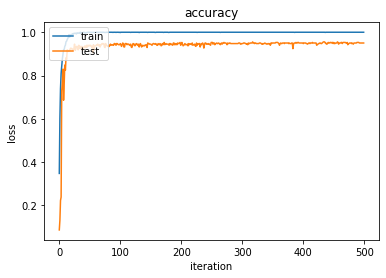

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist_simple.history['acc'])
plt.plot(hist_simple.history['val_acc'])
plt.title('accuracy')
plt.ylabel('loss') 
plt.xlabel('iteration')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# removing wrapper

In [ ]:
final_model_80 = sparsity.strip_pruning(new_pruned_model_80)
final_model_80.compile( loss=tf.keras.losses.categorical_crossentropy,
    optimizer="adam", metrics=['accuracy'])

final_model_85 = sparsity.strip_pruning(new_pruned_model_85)
final_model_85.compile( loss=tf.keras.losses.categorical_crossentropy,
    optimizer="adam", metrics=['accuracy'])

final_model_90 = sparsity.strip_pruning(new_pruned_model_90)
final_model_90.compile( loss=tf.keras.losses.categorical_crossentropy,
    optimizer="adam", metrics=['accuracy'])

final_model_95 = sparsity.strip_pruning(new_pruned_model_95)
final_model_95.compile( loss=tf.keras.losses.categorical_crossentropy,
    optimizer="adam", metrics=['accuracy'])

In [ ]:
score1 = model_simple.evaluate(X_test, y_test, verbose=1)
score2 = final_model_80.evaluate(X_test, y_test, verbose=1)
score3 = final_model_85.evaluate(X_test, y_test, verbose=1)
score4 = final_model_90.evaluate(X_test, y_test, verbose=1)
score5 = final_model_95.evaluate(X_test, y_test, verbose=1)
print('################## TEST ACCURACY ################################## ')
print('00 pruning :', score1[1])
print('80 pruning :', score2[1])
print('85 pruning :', score3[1])
print('90 pruning :', score4[1])
print('95 pruning :', score5[1])

print('################## TEST LOSS ################################## ')
print('00 pruning :', score1[0])
print('80 pruning :', score2[0])
print('85 pruning :', score3[0])
print('90 pruning :', score4[0])
print('95 pruning :', score5[0])

382/382 [==============================] - 1s 2ms/sample - loss: 0.3615 - acc: 0.9503
################## TEST ACCURACY ################################## 
00 pruning : 0.9502618
80 pruning : 0.947644
85 pruning : 0.92670155
90 pruning : 0.95811516
95 pruning : 0.9502618
################## TEST LOSS ################################## 
00 pruning : 0.24019075824796218
80 pruning : 0.20250941606248238
85 pruning : 0.6841450590403819
90 pruning : 0.15763234206675236
95 pruning : 0.36152518646979304


In [ ]:
simple_model_file = 'simple_model.h5'
tf.keras.models.save_model(model_simple, simple_model_file,
                        include_optimizer=False)
pruned_model_file_80 = 'pruned_model_80.h5'
tf.keras.models.save_model(final_model_80, pruned_model_file_80,
                        include_optimizer=False)

pruned_model_file_85 = 'pruned_model_85.h5'
tf.keras.models.save_model(final_model_85, pruned_model_file_85,
                        include_optimizer=False)

pruned_model_file_90 = 'pruned_model_90.h5'
tf.keras.models.save_model(final_model_90, pruned_model_file_90,
                        include_optimizer=False)

pruned_model_file_95 = 'pruned_model_95.h5'
tf.keras.models.save_model(final_model_95, pruned_model_file_95,
                        include_optimizer=False)

In [ ]:
simple_zip="simple_zip.zip"
with zipfile.ZipFile(simple_zip, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(simple_model_file)

pruned_80_zip="pruned_80_zip.zip"
with zipfile.ZipFile(pruned_80_zip, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_model_file_80)

pruned_85_zip="pruned_85_zip.zip"
with zipfile.ZipFile(pruned_85_zip, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_model_file_85)

pruned_90_zip="pruned_90_zip.zip"
with zipfile.ZipFile(pruned_90_zip, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_model_file_90)

pruned_95_zip="pruned_95_zip.zip"
with zipfile.ZipFile(pruned_95_zip, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_model_file_95)

#comparing size

In [ ]:
print("Size of the pruned 00 : %.2f Mb" 
      % (os.path.getsize(simple_model_file) / float(2**20)))
print("Size of the pruned 00 : %.2f Mb" 
      % (os.path.getsize(simple_zip) / float(2**20)))
print("Size of the pruned 80 : %.2f Mb" 
      % (os.path.getsize(pruned_80_zip) / float(2**20)))
print("Size of the pruned 85 : %.2f Mb" 
      % (os.path.getsize(pruned_85_zip) / float(2**20)))
print("Size of the pruned 90: %.2f Mb" 
      % (os.path.getsize(pruned_90_zip) / float(2**20)))
print("Size of the pruned 95: %.2f Mb" 
      % (os.path.getsize(pruned_95_zip) / float(2**20)))

Size of the pruned 00 : 42.61 Mb
Size of the pruned 00 : 39.09 Mb
Size of the pruned 80 : 12.01 Mb
Size of the pruned 85 : 10.54 Mb
Size of the pruned 90: 7.86 Mb
Size of the pruned 95: 5.80 Mb


#Quantization

In [ ]:
def quantModel(modelx, pathx, pathzip):
  converter = tf.lite.TFLiteConverter.from_keras_model_file(modelx)

  converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

  tflite_quant_model = converter.convert()

  tflite_quant_model_file = pathx
  with open(tflite_quant_model_file, 'wb') as f:
    f.write(tflite_quant_model)

  quant_zip=pathzip
  with zipfile.ZipFile(quant_zip, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(tflite_quant_model_file)

In [ ]:
quantModel(simple_model_file, "lite_00.tflite", "lite_00.zip")
quantModel(pruned_model_file_80, "lite_80.tflite", "lite_80.zip")
quantModel(pruned_model_file_85, "lite_85.tflite", "lite_85.zip")
quantModel(pruned_model_file_90, "lite_90.tflite", "lite_90.zip")
quantModel(pruned_model_file_95, "lite_95.tflite", "lite_95.zip")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.
INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.
INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.
INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.
INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.


Comparison after Pruning + Compression

In [ ]:
def eval_model(interpreter, x_test, y_test):
  total_seen = 0
  num_correct = 0

  for img, label in zip(x_test, y_test):
    inp = img.reshape((1, 50, 50, 3))
    total_seen += 1
    interpreter.set_tensor(input_index, inp)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    if np.argmax(predictions) == np.argmax(label):
      num_correct += 1

    if total_seen % 1000 == 0:
        print("Accuracy after %i images: %f" %
              (total_seen, float(num_correct) / float(total_seen)))

  return float(num_correct) / float(total_seen)



In [ ]:
interpreter = tf.lite.Interpreter(model_path=str("lite_00.tflite"))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
print(eval_model(interpreter, X_test, y_test))


0.9502617801047121


In [ ]:
interpreter = tf.lite.Interpreter(model_path=str("lite_80.tflite"))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
print(eval_model(interpreter, X_test, y_test))

0.9450261780104712


In [ ]:
interpreter = tf.lite.Interpreter(model_path=str("lite_85.tflite"))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
print(eval_model(interpreter, X_test, y_test))

0.9267015706806283


In [ ]:
interpreter = tf.lite.Interpreter(model_path=str("lite_90.tflite"))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
print(eval_model(interpreter, X_test, y_test))

0.9581151832460733


In [ ]:
interpreter = tf.lite.Interpreter(model_path=str("lite_95.tflite"))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
print(eval_model(interpreter, X_test, y_test))

0.9502617801047121
